
# Fundamentos de Cálculo y Optimización para Deep Learning  


In [29]:

# --- instalaciones ---
!pip -q install torch torchvision torchaudio
!pip -q install tensorflow==2.*
!pip -q install matplotlib numpy

import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import tensorflow as tf

print("Torch:", torch.__version__)
print("TensorFlow:", tf.__version__)


Torch: 2.8.0+cu126
TensorFlow: 2.19.0


In [30]:

# prints y checks de ints
def pretty_scalar_eval(name, x, f_val, d_val):
    print(f"{name:>3} @ x={x:>7.4f} -> f(x)={float(f_val):>12.6f} | f'(x)={float(d_val):>12.6f}")

def pretty_vector_eval(name, point, f_val, grad_vec):
    pstr = ", ".join([f"{v:.4f}" for v in point])
    gstr = ", ".join([f"{float(g):.6f}" for g in grad_vec])
    print(f"{name} @ ({pstr}) -> f={float(f_val):.6f} | grad=[{gstr}]")

def close(a, b, tol=1e-6):
    return abs(a - b) < tol


## Sección 1: Cálculo de Derivadas y Gradientes


### f₁(x) = 3x³ − 2x² + 5x − 1 (PyTorch autograd)  
Evaluar en: x = -1, 0, 2


In [31]:

# f1 PyTorch autograd
def f1_torch(x):
    return 3*x**3 - 2*x**2 + 5*x - 1

xs = [-1.0, 0.0, 2.0]
for xv in xs:
    x = torch.tensor(xv, dtype=torch.float64, requires_grad=True)
    y = f1_torch(x)
    y.backward()
    pretty_scalar_eval("f1", xv, y.item(), x.grad.item())


 f1 @ x=-1.0000 -> f(x)=  -11.000000 | f'(x)=   18.000000
 f1 @ x= 0.0000 -> f(x)=   -1.000000 | f'(x)=    5.000000
 f1 @ x= 2.0000 -> f(x)=   25.000000 | f'(x)=   33.000000



### f₂(x,y) = x² + y² − 2xy + 4x (PyTorch autograd)  
Evaluar en: (1,1), (-2,3), (0,0)  
Gradiente manual:  ∇f₂ = [2x − 2y + 4, 2y − 2x]


In [32]:

def f2_torch(x, y):
    return x**2 + y**2 - 2*x*y + 4*x

def grad_f2_manual(xv, yv):
    return np.array([2*xv - 2*yv + 4, 2*yv - 2*xv], dtype=np.float64)

points = [(1.0,1.0), (-2.0,3.0), (0.0,0.0)]
for (xv,yv) in points:
    x = torch.tensor(xv, dtype=torch.float64, requires_grad=True)
    y = torch.tensor(yv, dtype=torch.float64, requires_grad=True)
    f = f2_torch(x,y)
    f.backward()
    g_auto = np.array([x.grad.item(), y.grad.item()], dtype=np.float64)
    g_man = grad_f2_manual(xv,yv)
    pretty_vector_eval("f2", (xv,yv), f.item(), g_auto)
    print("  grad(manual) =", g_man, "| igualdad =:", np.allclose(g_auto, g_man, atol=1e-8))


f2 @ (1.0000, 1.0000) -> f=4.000000 | grad=[4.000000, 0.000000]
  grad(manual) = [4. 0.] | igualdad =: True
f2 @ (-2.0000, 3.0000) -> f=17.000000 | grad=[-6.000000, 10.000000]
  grad(manual) = [-6. 10.] | igualdad =: True
f2 @ (0.0000, 0.0000) -> f=0.000000 | grad=[4.000000, 0.000000]
  grad(manual) = [4. 0.] | igualdad =: True



### f₃(x) = e^{−x²} · cos(x) (PyTorch autograd)  
Evaluar en: x = 0, π/4, 1  

Derivada manual:  d/dx [e^{-x^2} cos x] = e^{-x^2}(-2x cos x − sin x)


In [33]:

def f3_torch(x):
    return torch.exp(-x**2) * torch.cos(x)

def df3_manual(x):
    return math.exp(-x**2) * (-2*x*math.cos(x) - math.sin(x))

xs = [0.0, math.pi/4, 1.0]
for xv in xs:
    x = torch.tensor(xv, dtype=torch.float64, requires_grad=True)
    y = f3_torch(x)
    y.backward()
    d_auto = x.grad.item()
    d_man = df3_manual(xv)
    pretty_scalar_eval("f3", xv, y.item(), d_auto)
    print(f"  d(manual) = {d_man:.12f} | igualdad =: {abs(d_auto - d_man) < 1e-9}")


 f3 @ x= 0.0000 -> f(x)=    1.000000 | f'(x)=   -0.000000
  d(manual) = -0.000000000000 | igualdad =: True
 f3 @ x= 0.7854 -> f(x)=    0.381584 | f'(x)=   -0.980975
  d(manual) = -0.980975141544 | igualdad =: True
 f3 @ x= 1.0000 -> f(x)=    0.198766 | f'(x)=   -0.707092
  d(manual) = -0.707092096346 | igualdad =: True



### f₄(x,y,z) = x²y + y²z + z²x (PyTorch autograd)  
Evaluar en: (1,2,3), (-1,0,1), (2,2,2)


In [34]:

def f4_torch(x,y,z):
    return x**2 * y + y**2 * z + z**2 * x

points = [(1,2,3), (-1,0,1), (2,2,2)]
for (a,b,c) in points:
    x = torch.tensor(float(a), dtype=torch.float64, requires_grad=True)
    y = torch.tensor(float(b), dtype=torch.float64, requires_grad=True)
    z = torch.tensor(float(c), dtype=torch.float64, requires_grad=True)
    f = f4_torch(x,y,z)
    f.backward()
    grad_vec = [x.grad.item(), y.grad.item(), z.grad.item()]
    pretty_vector_eval("f4", (a,b,c), f.item(), grad_vec)


f4 @ (1.0000, 2.0000, 3.0000) -> f=23.000000 | grad=[13.000000, 13.000000, 10.000000]
f4 @ (-1.0000, 0.0000, 1.0000) -> f=-1.000000 | grad=[1.000000, 1.000000, -2.000000]
f4 @ (2.0000, 2.0000, 2.0000) -> f=24.000000 | grad=[12.000000, 12.000000, 12.000000]



### f₅(x) = ln(1 + x²) + sin(2x) (TensorFlow)  
Evaluar en: x = -1, 0.5, 2


In [35]:

def f5_tf(x):
    return tf.math.log(1.0 + x**2) + tf.math.sin(2.0*x)

for xv in [-1.0, 0.5, 2.0]:
    x = tf.Variable(xv, dtype=tf.float64)
    with tf.GradientTape() as tape:
        y = f5_tf(x)
    dy = tape.gradient(y, x)
    pretty_scalar_eval("f5", xv, y.numpy().item(), dy.numpy().item())


 f5 @ x=-1.0000 -> f(x)=   -0.216150 | f'(x)=   -1.832294
 f5 @ x= 0.5000 -> f(x)=    1.064615 | f'(x)=    1.880605
 f5 @ x= 2.0000 -> f(x)=    0.852635 | f'(x)=   -0.507287



## Sección 2: Optimización con Gradient Descent

**Requisitos**:
Implementa gradient descent desde cero (sin usar optimizadores predefinidos como optim.SGD)

Prueba varios learning rates y analizad(agregando un comentario) de que sucede con valores muy pequeños o muy grandes

Detén el algoritmo cuando |∇f| < 0.001 o después de 10,000 iteraciones

Recuerda que el gradiente da la dirección de máximo incremento(para maximiar) de las funciones y el negativo la dirección de máximo decremento(para minimizar)

Recuerda que minimizar es equivalente a maximizar el negativo de la función

Grafica la evolución del valor de la función durante las iteraciones

Reporta: número de iteraciones, valor final encontrado, y error respecto al target


In [36]:

def gradient_descent(f, grad, x0, lr=0.05, max_iter=10_000, tol=1e-3, maximize=False):
    x = np.array(x0, dtype=np.float64)
    hist = []
    for it in range(max_iter):
        g = np.array(grad(x), dtype=np.float64)
        g_norm = np.linalg.norm(g)
        val = float(f(x))
        hist.append(val)
        if g_norm < tol:
            return x, val, it+1, np.array(hist)
        step = lr * g
        x = x + step if maximize else x - step
    return x, float(f(x)), max_iter, np.array(hist)

def plot_history(histories, title):
    plt.figure()
    for label, hist in histories:
        plt.plot(hist, label=label)
    plt.xlabel("Iteracion")
    plt.ylabel("Valor de la funcion")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



### Minimización: g₁(x) = (x − 3)² + 5  
Target: x* = 3, f(x*) = 5. — Punto inicial: x₀ = 10.


[g1 | lr=0.001] iters=4770, x_final=3.000500, f_final=5.000000, |x-3|=4.996311e-04, |f-5|=2.496312e-07
[g1 | lr=0.05] iters=92, x_final=3.000480, f_final=5.000000, |x-3|=4.799173e-04, |f-5|=2.303206e-07
[g1 | lr=0.4] iters=7, x_final=3.000448, f_final=5.000000, |x-3|=4.480000e-04, |f-5|=2.007040e-07


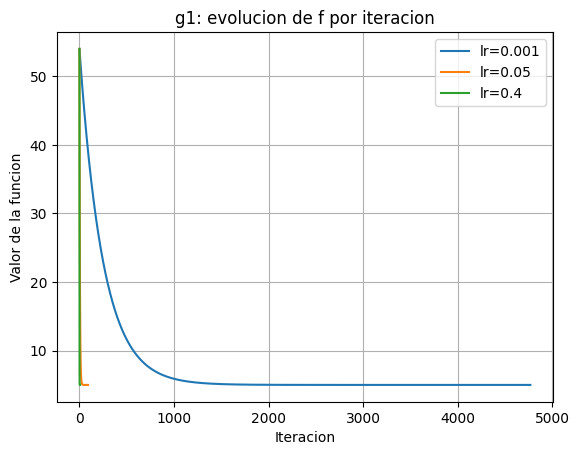

In [37]:

def g1(x):
    xv = float(x)
    return (xv - 3)**2 + 5

def grad_g1(x):
    xv = float(x)
    return 2*(xv - 3)

lrs = [0.001, 0.05, 0.4]
histories = []
for lr in lrs:
    xf, vf, iters, hist = gradient_descent(g1, grad_g1, x0=10.0, lr=lr, maximize=False)
    dist_x = abs(float(xf) - 3.0)
    err_f = abs(vf - 5.0)
    print(f"[g1 | lr={lr}] iters={iters}, x_final={float(xf):.6f}, f_final={vf:.6f}, |x-3|={dist_x:.6e}, |f-5|={err_f:.6e}")
    histories.append((f"lr={lr}", hist))

plot_history(histories, "g1: evolucion de f por iteracion")


### Minimización: g₂(x,y) = (x − 2)² + (y + 1)² + 10  
Target: (2, −1), f* = 10. — Punto inicial: (−5, 5).


[g2 | lr=0.005] iters=979, (x,y)_final=[ 1.99962302 -0.99967687], f_final=10.000000, ||(x,y)-(2,-1)||=4.965120e-04, |f-10|=2.465242e-07
[g2 | lr=0.1] iters=46, (x,y)_final=[ 1.99969511 -0.99973866], f_final=10.000000, ||(x,y)-(2,-1)||=4.015678e-04, |f-10|=1.612567e-07
[g2 | lr=0.35] iters=10, (x,y)_final=[ 1.99986222 -0.9998819 ], f_final=10.000000, ||(x,y)-(2,-1)||=1.814683e-04, |f-10|=3.293074e-08


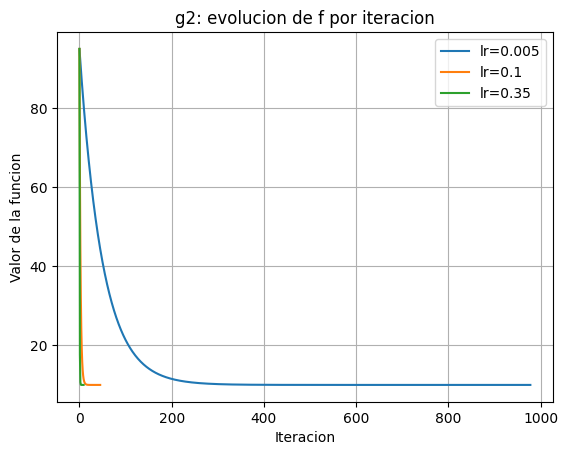

In [38]:

def g2(v):
    x, y = float(v[0]), float(v[1])
    return (x-2)**2 + (y+1)**2 + 10

def grad_g2(v):
    x, y = float(v[0]), float(v[1])
    return np.array([2*(x-2), 2*(y+1)])

lrs = [0.005, 0.1, 0.35]
histories = []
for lr in lrs:
    xf, vf, iters, hist = gradient_descent(g2, grad_g2, x0=np.array([-5.0, 5.0]), lr=lr, maximize=False)
    dist_xy = np.linalg.norm(xf - np.array([2.0, -1.0]))
    err_f = abs(vf - 10.0)
    print(f"[g2 | lr={lr}] iters={iters}, (x,y)_final={xf}, f_final={vf:.6f}, ||(x,y)-(2,-1)||={dist_xy:.6e}, |f-10|={err_f:.6e}")
    histories.append((f"lr={lr}", hist))

plot_history(histories, "g2: evolucion de f por iteracion")



### Minimización: g₃(x,y) = x² + 2y² − 2xy + 2x − 4y + 8  
Target aproximado: f(x*,y*) ≈ 5.5. — Punto inicial: (0,0).


[g3 | lr=0.01] iters=783, (x,y)_final=[-0.00111199  0.99931275], f_final=6.000001, |f-5.5|=5.000007e-01
[g3 | lr=0.08] iters=97, (x,y)_final=[-0.00105033  0.99935086], f_final=6.000001, |f-5.5|=5.000006e-01
[g3 | lr=0.2] iters=38, (x,y)_final=[-9.68841883e-04  9.99401223e-01], f_final=6.000000, |f-5.5|=5.000005e-01


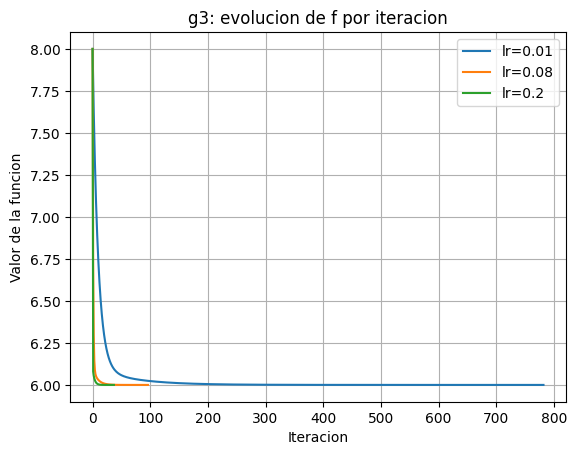

In [39]:

def g3(v):
    x, y = float(v[0]), float(v[1])
    return x**2 + 2*y**2 - 2*x*y + 2*x - 4*y + 8

def grad_g3(v):
    x, y = float(v[0]), float(v[1])
    # df/dx = 2x - 2y + 2
    # df/dy = 4y - 2x - 4
    return np.array([2*x - 2*y + 2, 4*y - 2*x - 4])

lrs = [0.01, 0.08, 0.2]
histories = []
for lr in lrs:
    xf, vf, iters, hist = gradient_descent(g3, grad_g3, x0=np.array([0.0, 0.0]), lr=lr, maximize=False)
    err_f = abs(vf - 5.5)
    print(f"[g3 | lr={lr}] iters={iters}, (x,y)_final={xf}, f_final={vf:.6f}, |f-5.5|={err_f:.6e}")
    histories.append((f"lr={lr}", hist))

plot_history(histories, "g3: evolucion de f por iteracion")



### Maximización: h₁(x) = −x² + 4x + 1  
Target: x* = 2, h(x*) = 5. — Punto inicial: x₀ = −3.  
(Maximizar h ≡ minimizar −h; aquí hacemos **ascenso** por gradiente.)


[h1 | lr=0.01] iters=457, x_final=1.999501, h_final=5.000000, |x-2|=4.989540e-04, |h-5|=2.489551e-07
[h1 | lr=0.1] iters=43, x_final=1.999575, h_final=5.000000, |x-2|=4.253530e-04, |h-5|=1.809251e-07
[h1 | lr=0.35] iters=9, x_final=1.999672, h_final=5.000000, |x-2|=3.280500e-04, |h-5|=1.076168e-07


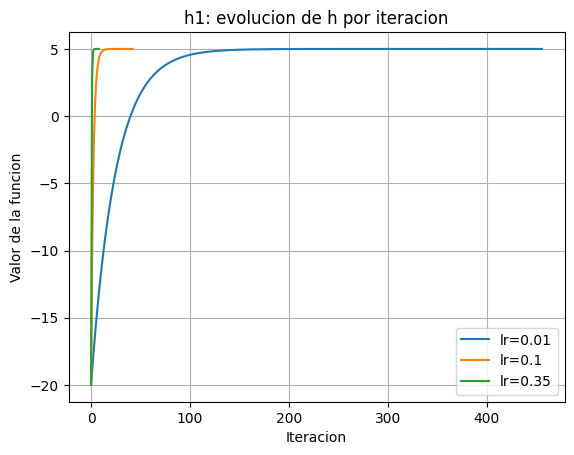

In [40]:

def h1(x):
    xv = float(x)
    return -xv**2 + 4*xv + 1

def grad_h1(x):
    xv = float(x)
    return -2*xv + 4

lrs = [0.01, 0.1, 0.35]
histories = []
for lr in lrs:
    xf, vf, iters, hist = gradient_descent(h1, grad_h1, x0=-3.0, lr=lr, maximize=True)
    dist_x = abs(float(xf) - 2.0)
    err_f = abs(vf - 5.0)
    print(f"[h1 | lr={lr}] iters={iters}, x_final={float(xf):.6f}, h_final={vf:.6f}, |x-2|={dist_x:.6e}, |h-5|={err_f:.6e}")
    histories.append((f"lr={lr}", hist))

plot_history(histories, "h1: evolucion de h por iteracion")



### Maximización: h₂(x,y) = −(x−1)² − (y−2)² + 10  
Target: (1,2), h* = 10. — Punto inicial: (5, −2).


[h2 | lr=0.02] iters=230, (x,y)_final=[1.00034848 1.99965152], h_final=10.000000, ||(x,y)-(1,2)||=4.928189e-04, |h-10|=2.428705e-07
[h2 | lr=0.15] iters=28, (x,y)_final=[1.00026285 1.99973715], h_final=10.000000, ||(x,y)-(1,2)||=3.717253e-04, |h-10|=1.381797e-07
[h2 | lr=0.4] iters=7, (x,y)_final=[1.000256 1.999744], h_final=10.000000, ||(x,y)-(1,2)||=3.620387e-04, |h-10|=1.310720e-07


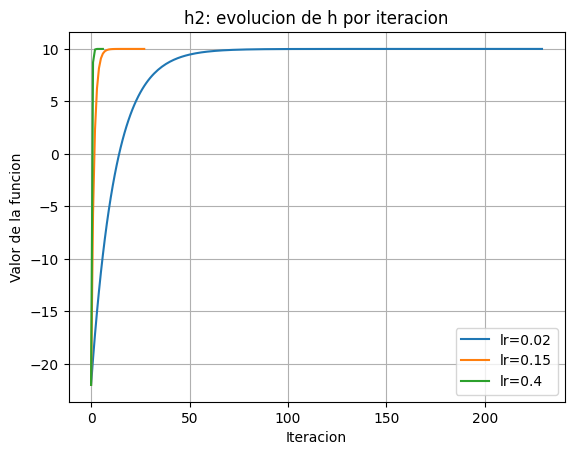

In [41]:

def h2(v):
    x, y = float(v[0]), float(v[1])
    return - (x-1)**2 - (y-2)**2 + 10

def grad_h2(v):
    x, y = float(v[0]), float(v[1])
    # grad = [ -2(x-1), -2(y-2) ]
    return np.array([-2*(x-1), -2*(y-2)])

lrs = [0.02, 0.15, 0.4]
histories = []
for lr in lrs:
    xf, vf, iters, hist = gradient_descent(h2, grad_h2, x0=np.array([5.0, -2.0]), lr=lr, maximize=True)
    dist_xy = np.linalg.norm(xf - np.array([1.0, 2.0]))
    err_f = abs(vf - 10.0)
    print(f"[h2 | lr={lr}] iters={iters}, (x,y)_final={xf}, h_final={vf:.6f}, ||(x,y)-(1,2)||={dist_xy:.6e}, |h-10|={err_f:.6e}")
    histories.append((f"lr={lr}", hist))

plot_history(histories, "h2: evolucion de h por iteracion")
